In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
from LinearKalmanNet import LinearKalmanNet
from KalmanNet2 import KalmanNet2
from KalmanNet import KalmanNet
from utils import generate_data, train
from Kalman import KalmanFilter
from ExtendedKalmanFilter import ExtendedKalmanFilter
from UnscentedKalmanFilter import UnscentedKalmanFilter
from LinearSystem import LinearSystem
from NonLinearSystem import NonlinearSystem
from torch.utils.data import TensorDataset, DataLoader, random_split
from utils import train_with_scheduler


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cpu


# Testcase 1: Lineární systém
Předpoklad, že uvažovaný model systému je identický jako samotný systém. Kromě počátečních podmínek.

In [18]:
# --- Reálný systém ---
F_true = torch.tensor([[0.5]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Očekávaná hodnota počátečního stavu
P0_true = torch.tensor([[1.2]])  # Počáteční kov

sys_true = LinearSystem(Ex0_true,P0_true,F_true, H_true, Q_true, R_true)

Ex0_model = torch.tensor([[0.5]])  # Očekávaná hodnota počátečního stavu
P0_model = torch.tensor([[1.5]])  # Počáteční kov

F_model = F_true
H_model = H_true
Q_model = Q_true
R_model = R_true
sys_model = LinearSystem(Ex0_model,P0_model,F_model,H_model,Q_model,R_model)


In [19]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200) # Jedna delší trajektorie pro test


KeyboardInterrupt: 

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
kalman_filter = KalmanFilter(Ex0_model, P0_model, F_model, H_model, Q_model, R_model)
kf_data = kalman_filter.apply_filter(y_test[0])
x_hat_kf = kf_data['x_filtered']

In [ ]:
knet = LinearKalmanNet(sys_model,128).to(device)
train(knet, train_loader,device,epochs=50, lr=1e-4)

/home/luky/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.057165, Celková norma grad.: 0.0326
Epocha [10/50], Prům. chyba: 0.055653, Celková norma grad.: 0.0185
Epocha [15/50], Prům. chyba: 0.054986, Celková norma grad.: 0.0258
Epocha [20/50], Prům. chyba: 0.054485, Celková norma grad.: 0.0178
Epocha [25/50], Prům. chyba: 0.054139, Celková norma grad.: 0.0058
Epocha [30/50], Prům. chyba: 0.053953, Celková norma grad.: 0.0181
Epocha [35/50], Prům. chyba: 0.053753, Celková norma grad.: 0.0140
Epocha [40/50], Prům. chyba: 0.053683, Celková norma grad.: 0.0126
Epocha [45/50], Prům. chyba: 0.053706, Celková norma grad.: 0.0265
Epocha [50/50], Prům. chyba: 0.053572, Celková norma grad.: 0.0141
Trénování dokončeno.


In [ ]:
knet.eval()
with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_test_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_test_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_kf = mse_criterion(x_hat_kf, x_test[0])

print(f"\nVýsledná MSE KalmanNet: {mse_knet.item():.4f}")
print(f"Výsledná MSE klasického KF: {mse_kf.item():.4f}")


Výsledná MSE KalmanNet: 0.0490
Výsledná MSE klasického KF: 0.0492


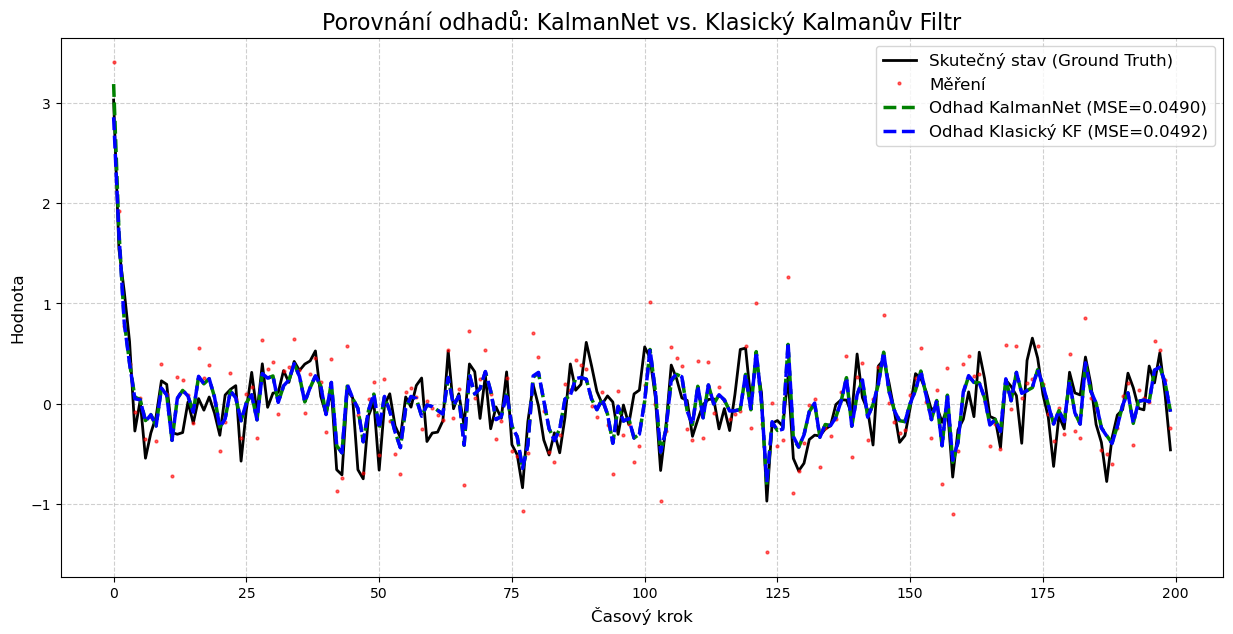

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Porovnání odhadů: KalmanNet vs. Klasický Kalmanův Filtr", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_kf_plot = x_hat_kf.squeeze().numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=4, alpha=0.6, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_kf_plot, 'b--', linewidth=2.5, label=f"Odhad Klasický KF (MSE={mse_kf.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Testcase 2: Nelineární systém
Předpoklad, že uvažovaný model systému je identický jako samotný systém

In [ ]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[1.0]])
sys_model= NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [ ]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
ekf = ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']

In [ ]:
knet_nelinearni = KalmanNet(sys_model).to(device)
train(knet_nelinearni, train_loader, device, epochs=50, lr=1e-4)

In [ ]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train(knet2, train_loader, device, epochs=50, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()

In [ ]:
knet = knet_nelinearni
knet.eval()

with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_ekf = mse_criterion(x_hat_ekf, x_test)
mse_knet2 = mse_criterion(x_hat_knet2, x_test)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")
print(f"Výsledná MSE EKF na nelineárním systému:       {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")

plt.figure(figsize=(16, 8))
plt.title("Porovnání EKF vs. KalmanNet Arch. #1 vs. Arch. #2 (Perfektní model)", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_ekf_plot = x_hat_ekf.numpy()
x_hat_knet2_plot = x_hat_knet2.squeeze().numpy()


plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_ekf_plot, 'b-.', linewidth=2.5, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet2_plot, 'y:', linewidth=2.5, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")


plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Testcase 3: Nelineární systém s nepřesným modelem

In [ ]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = R_true
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[1.0]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
sys_model = NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)

In [ ]:

x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
ekf = ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']

In [ ]:
knet_nelinearni = KalmanNet(sys_model,device).to(device)
train(knet_nelinearni, train_loader, device, epochs=50, lr=1e-4)

Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.145979, Celková norma grad.: 0.0164
Epocha [10/50], Prům. chyba: 0.145170, Celková norma grad.: 0.0213
Epocha [15/50], Prům. chyba: 0.144088, Celková norma grad.: 0.0139
Epocha [20/50], Prům. chyba: 0.143072, Celková norma grad.: 0.0171
Epocha [25/50], Prům. chyba: 0.142197, Celková norma grad.: 0.0132
Epocha [30/50], Prům. chyba: 0.141230, Celková norma grad.: 0.0142
Epocha [35/50], Prům. chyba: 0.140129, Celková norma grad.: 0.0377
Epocha [40/50], Prům. chyba: 0.139075, Celková norma grad.: 0.0139
Epocha [45/50], Prům. chyba: 0.138195, Celková norma grad.: 0.0332
Epocha [50/50], Prům. chyba: 0.137477, Celková norma grad.: 0.0135
Trénování dokončeno.


In [ ]:
from KalmanNet2 import KalmanNet2
print("\n--- Trénování KalmanNet Architektury #2 ---")
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train(knet2, train_loader, device, epochs=50, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #2 ---
Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.330015, Celková norma grad.: 2.2289
Epocha [10/50], Prům. chyba: 0.231871, Celková norma grad.: 1.1173
Epocha [15/50], Prům. chyba: 0.182911, Celková norma grad.: 0.5633
Epocha [20/50], Prům. chyba: 0.163015, Celková norma grad.: 0.3980
Epocha [25/50], Prům. chyba: 0.153145, Celková norma grad.: 0.2893
Epocha [30/50], Prům. chyba: 0.147739, Celková norma grad.: 0.1810
Epocha [35/50], Prům. chyba: 0.145180, Celková norma grad.: 0.1171
Epocha [40/50], Prům. chyba: 0.143357, Celková norma grad.: 0.1027
Epocha [45/50], Prům. chyba: 0.142582, Celková norma grad.: 0.0800
Epocha [50/50], Prům. chyba: 0.142081, Celková norma grad.: 0.0317
Trénování dokončeno.



Výsledná MSE KalmanNet na nelineárním systému: 0.1608
Výsledná MSE EKF na nelineárním systému:       0.2841
Výsledná MSE KalmanNet (Arch. #2):     0.1593


/home/luky/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 200, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


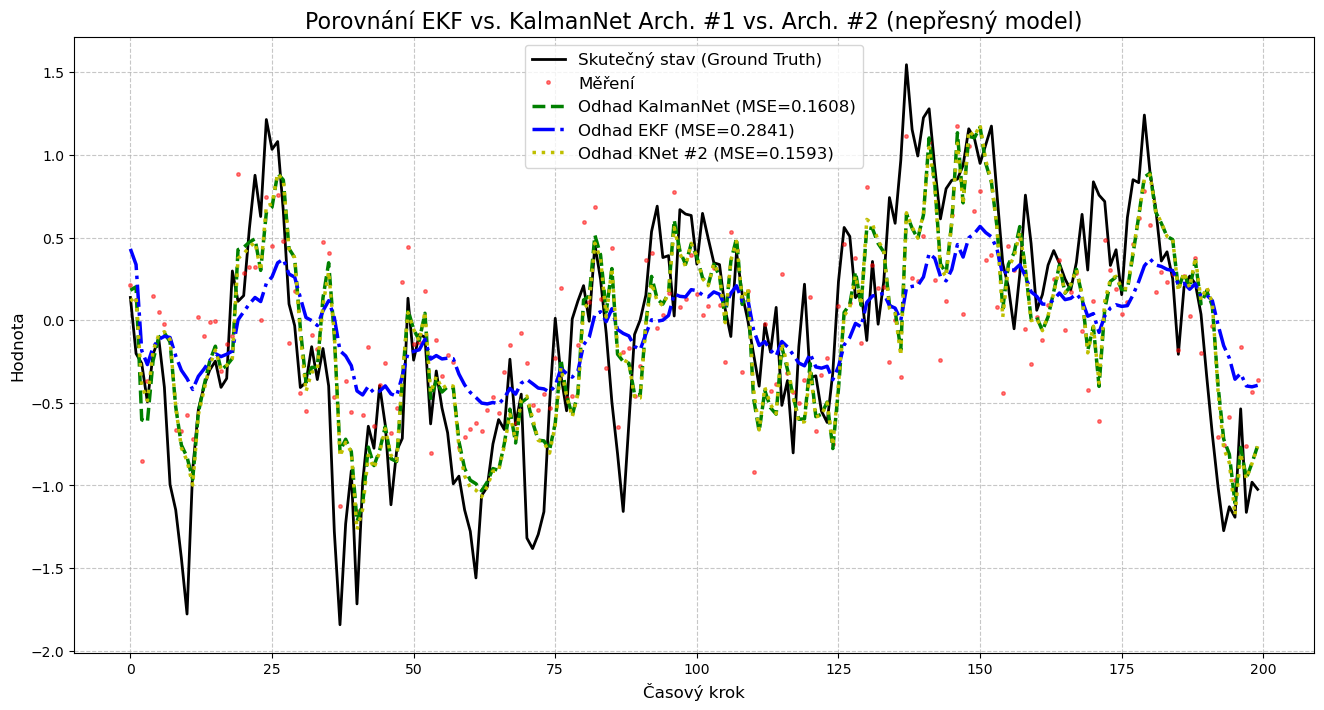

In [ ]:
knet = knet_nelinearni
knet.eval()

with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_ekf = mse_criterion(x_hat_ekf, x_test)
mse_knet2 = mse_criterion(x_hat_knet2, x_test)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")
print(f"Výsledná MSE EKF na nelineárním systému:       {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")

plt.figure(figsize=(16, 8))
plt.title("Porovnání EKF vs. KalmanNet Arch. #1 vs. Arch. #2 (nepřesný model)", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_ekf_plot = x_hat_ekf.numpy()
x_hat_knet2_plot = x_hat_knet2.squeeze().numpy()


plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_ekf_plot, 'b-.', linewidth=2.5, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet2_plot, 'y:', linewidth=2.5, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")


plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Testcase 4: Sledování lodi (bez vstupu)

In [ ]:
dt = 0.02

F = torch.tensor([
    [1,0,dt,0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ],dtype=torch.float32
).to(device)

f_true = lambda x: F @ x

def h_true_nonlinear(x):
    x_pos, y_pos = x[0], x[1]
    angle = torch.atan2(y_pos, x_pos)
    distance = torch.sqrt(x_pos**2 + y_pos**2)
    return torch.stack([angle,distance])

Q_true = (torch.eye(4) * 10e-6).to(device)
R_true = torch.tensor([[4e-4*(torch.pi/180)**2, 0], [0, 1e-4]],dtype=torch.float32).to(device)
P0_true = torch.eye(4).to(device)
Ex0_true = torch.tensor([[20, 50, 0,-12]],dtype=torch.float32).T.to(device)

sys_true = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

sys_model = sys_true

In [ ]:
print("\n--- Generování dat pro zjednodušené sledování lodi ---")
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True)


--- Generování dat pro zjednodušené sledování lodi ---


In [ ]:
print("\n--- Evaluace EKF ---")
ekf = ExtendedKalmanFilter(sys_model)
ekf_results = ekf.apply_filter(y_test.squeeze(0))
x_hat_ekf = ekf_results['x_filtered']


--- Evaluace EKF ---


In [ ]:
print("\n--- Trénování KalmanNet Architektury #1 ---")
# hidden_size_multiplier může být menší, problém je jednodušší
knet1 = KalmanNet(sys_model, device, hidden_size_multiplier=10).to(device)
train(knet1, train_loader, device, epochs=50, lr=1e-4)
knet1.eval()
with torch.no_grad():
    x_hat_knet1 = knet1(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #1 ---
Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 3.562881, Celková norma grad.: 29.4474
Epocha [10/50], Prům. chyba: 0.318606, Celková norma grad.: 6.5517
Epocha [15/50], Prům. chyba: 0.212358, Celková norma grad.: 7.6726
Epocha [20/50], Prům. chyba: 0.177619, Celková norma grad.: 6.0385
Epocha [25/50], Prům. chyba: 0.157447, Celková norma grad.: 21.8978
Epocha [30/50], Prům. chyba: 0.143717, Celková norma grad.: 6.8586
Epocha [35/50], Prům. chyba: 0.132404, Celková norma grad.: 9.5803
Epocha [40/50], Prům. chyba: 0.124435, Celková norma grad.: 7.2307
Epocha [45/50], Prům. chyba: 0.121969, Celková norma grad.: 2.8164
Epocha [50/50], Prům. chyba: 0.112164, Celková norma grad.: 1.8111
Trénování dokončeno.


In [ ]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
# Multiplikátory mohou být menší
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train(knet2, train_loader, device, epochs=40, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #2 ---
Zahajuji trénování KalmanNetu...
Epocha [5/40], Prům. chyba: 4.808059, Celková norma grad.: 50.9155
Epocha [10/40], Prům. chyba: 0.553502, Celková norma grad.: 10.6121
Epocha [15/40], Prům. chyba: 0.380425, Celková norma grad.: 21.3298
Epocha [20/40], Prům. chyba: 0.275356, Celková norma grad.: 11.7980
Epocha [25/40], Prům. chyba: 0.216884, Celková norma grad.: 12.1561
Epocha [30/40], Prům. chyba: 0.196232, Celková norma grad.: 5.2587
Epocha [35/40], Prům. chyba: 0.195736, Celková norma grad.: 13.0431
Epocha [40/40], Prům. chyba: 0.174899, Celková norma grad.: 9.0272
Trénování dokončeno.


In [ ]:
x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_ekf_pos = x_hat_ekf[:, :2].cpu()
x_hat_knet1_pos = x_hat_knet1.squeeze(0)[:, :2]
x_hat_knet2_pos = x_hat_knet2.squeeze(0)[:, :2]

mse_ekf = torch.mean(torch.norm(x_hat_ekf_pos - x_true_pos, dim=1)**2)
mse_knet1 = torch.mean(torch.norm(x_hat_knet1_pos - x_true_pos, dim=1)**2)
mse_knet2 = torch.mean(torch.norm(x_hat_knet2_pos - x_true_pos, dim=1)**2)

print("\n--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---")
print(f"Výsledná MSE EKF:                      {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #1):     {mse_knet1.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")


--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---
Výsledná MSE EKF:                      0.0001
Výsledná MSE KalmanNet (Arch. #1):     0.0280
Výsledná MSE KalmanNet (Arch. #2):     0.0504


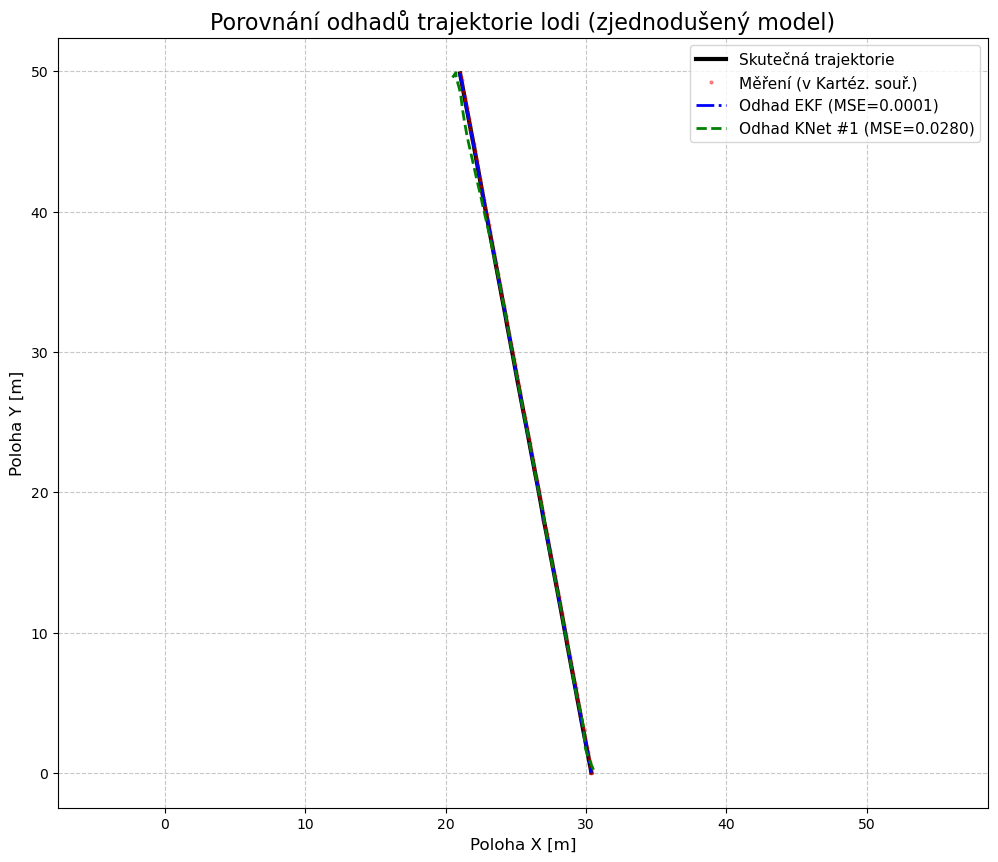

In [ ]:
plt.figure(figsize=(12, 10))
plt.title("Porovnání odhadů trajektorie lodi (zjednodušený model)", fontsize=16)

y_test_seq = y_test.squeeze(0).cpu()
angles = y_test_seq[:, 0].cpu()
distances = y_test_seq[:, 1].cpu()
y_meas_x = distances * torch.cos(angles)
y_meas_y = distances * torch.sin(angles)

plt.plot(x_true_pos[:, 0], x_true_pos[:, 1], 'k-', linewidth=3, label="Skutečná trajektorie")
plt.plot(y_meas_x, y_meas_y, 'r.', markersize=4, alpha=0.4, label="Měření (v Kartéz. souř.)")
plt.plot(x_hat_ekf_pos[:, 0], x_hat_ekf_pos[:, 1], 'b-.', linewidth=2, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet1_pos[:, 0], x_hat_knet1_pos[:, 1], 'g--', linewidth=2, label=f"Odhad KNet #1 (MSE={mse_knet1.item():.4f})")
# plt.plot(x_hat_knet2_pos[:, 0], x_hat_knet2_pos[:, 1], 'm:', linewidth=2, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")

plt.xlabel("Poloha X [m]", fontsize=12)
plt.ylabel("Poloha Y [m]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.axis('equal')
plt.show()

# Test adaptivniho LR na sledovani polohy lodi

In [4]:
dt = 0.02

F = torch.tensor([
    [1,0,dt,0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ],dtype=torch.float32
).to(device)

f_true = lambda x: F @ x

def h_true_nonlinear(x):
    x_pos, y_pos = x[0], x[1]
    angle = torch.atan2(y_pos, x_pos)
    distance = torch.sqrt(x_pos**2 + y_pos**2)
    return torch.stack([angle,distance])

Q_true = (torch.eye(4) * 10e-6).to(device)
R_true = torch.tensor([[4e-4*(torch.pi/180)**2, 0], [0, 1e-4]],dtype=torch.float32).to(device)
P0_true = torch.eye(4).to(device)
Ex0_true = torch.tensor([[20, 50, 0,-12]],dtype=torch.float32).T.to(device)

sys_true = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

P0_model = torch.eye(4).to(device)
Ex0_model = torch.tensor([[10, 40, 0,-20]],dtype=torch.float32).T.to(device)

sys_model = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [ ]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

full_train_dataset = TensorDataset(x_train, y_train)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [6]:
ekf = ExtendedKalmanFilter(sys_model)
ekf_results = ekf.apply_filter(y_test.squeeze(0))
x_hat_ekf = ekf_results['x_filtered']

In [7]:
ukf = UnscentedKalmanFilter(sys_model)
ukf_results = ukf.apply_filter(y_test.squeeze(0))
x_hat_ukf = ukf_results['x_filtered']

In [9]:
print("\n--- Trénování KalmanNet Architektury #1 ---")
knet1 = KalmanNet(sys_model, device, hidden_size_multiplier=10).to(device)
train_with_scheduler(knet1, train_loader, val_loader, device, epochs=200, lr=1e-4)
knet1.eval()
with torch.no_grad():
    x_hat_knet1 = knet1(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #1 ---
Zahajuji trénování KalmanNetu s dynamickým LR a Early Stopping...
Epocha [5/200], Train Loss: 2.765794, Val Loss: 2.133229
Epocha [10/200], Train Loss: 0.284685, Val Loss: 0.301500
Epocha [15/200], Train Loss: 0.221019, Val Loss: 0.237122
Epocha [20/200], Train Loss: 0.163221, Val Loss: 0.174528
Epocha [25/200], Train Loss: 0.142599, Val Loss: 0.155541
Epocha [30/200], Train Loss: 0.130635, Val Loss: 0.140373
Epocha [35/200], Train Loss: 0.117530, Val Loss: 0.137048
Epocha [40/200], Train Loss: 0.111535, Val Loss: 0.117030
Epocha [45/200], Train Loss: 0.102692, Val Loss: 0.113436
Epocha [50/200], Train Loss: 0.092820, Val Loss: 0.103574
Epocha [55/200], Train Loss: 0.094433, Val Loss: 0.108109
Epocha [60/200], Train Loss: 0.087014, Val Loss: 0.093417
Epocha [65/200], Train Loss: 0.078570, Val Loss: 0.108230
Epocha [70/200], Train Loss: 0.079395, Val Loss: 0.085136
Epocha [75/200], Train Loss: 0.074421, Val Loss: 0.089089
Epocha [80/200], Tra

In [10]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
# Multiplikátory mohou být menší
knet2 = KalmanNet2(sys_model, in_mult=10, out_mult=20).to(device)
train_with_scheduler(knet2, train_loader, val_loader, device, epochs=200, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #2 ---
Zahajuji trénování KalmanNetu s dynamickým LR a Early Stopping...


/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epocha [5/200], Train Loss: 4.584253, Val Loss: 3.717180
Epocha [10/200], Train Loss: 0.666384, Val Loss: 0.696165
Epocha [15/200], Train Loss: 0.437249, Val Loss: 0.499820
Epocha [20/200], Train Loss: 0.322894, Val Loss: 0.376772
Epocha [25/200], Train Loss: 0.276860, Val Loss: 0.277743
Epocha [30/200], Train Loss: 0.202181, Val Loss: 0.217309
Epocha [35/200], Train Loss: 0.183009, Val Loss: 0.199106
Epocha [40/200], Train Loss: 0.161282, Val Loss: 0.175015
Epocha [45/200], Train Loss: 0.156308, Val Loss: 0.176898
Epocha [50/200], Train Loss: 0.141662, Val Loss: 0.168174
Epocha [55/200], Train Loss: 0.141314, Val Loss: 0.148256
Epocha [60/200], Train Loss: 0.121244, Val Loss: 0.133934
Epocha [65/200], Train Loss: 0.107523, Val Loss: 0.117567
Epocha [70/200], Train Loss: 0.089220, Val Loss: 0.101392
Epocha [75/200], Train Loss: 0.083531, Val Loss: 0.095629
Epocha [80/200], Train Loss: 0.071339, Val Loss: 0.073745
Epocha [85/200], Train Loss: 0.061270, Val Loss: 0.078536
Epocha [90/200]

In [11]:
x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_ekf_pos = x_hat_ekf[:, :2].cpu()
x_hat_ukf_pos = x_hat_ukf[:, :2].cpu()
x_hat_knet1_pos = x_hat_knet1.squeeze(0)[:, :2]
x_hat_knet2_pos = x_hat_knet2.squeeze(0)[:, :2]

mse_ekf = torch.mean(torch.norm(x_hat_ekf_pos - x_true_pos, dim=1)**2)
mse_ukf = torch.mean(torch.norm(x_hat_ukf_pos - x_true_pos, dim=1)**2)
mse_knet1 = torch.mean(torch.norm(x_hat_knet1_pos - x_true_pos, dim=1)**2)
mse_knet2 = torch.mean(torch.norm(x_hat_knet2_pos - x_true_pos, dim=1)**2)

print("\n--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---")
print(f"Výsledná MSE EKF:                      {mse_ekf.item():.4f}")
print(f"Výsledná MSE UKF:                      {mse_ukf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #1):     {mse_knet1.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")


--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---
Výsledná MSE EKF:                      0.0273
Výsledná MSE UKF:                      0.0158
Výsledná MSE KalmanNet (Arch. #1):     0.0130
Výsledná MSE KalmanNet (Arch. #2):     0.0076


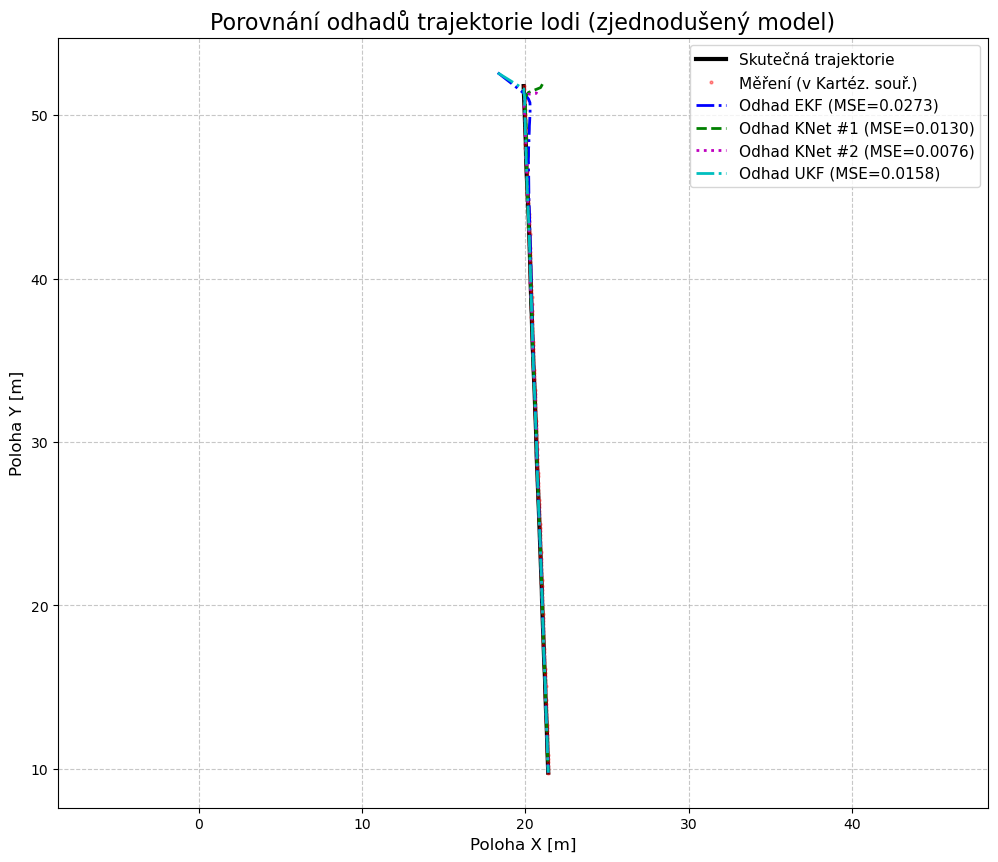

In [12]:
plt.figure(figsize=(12, 10))
plt.title("Porovnání odhadů trajektorie lodi (zjednodušený model)", fontsize=16)

y_test_seq = y_test.squeeze(0).cpu()
angles = y_test_seq[:, 0].cpu()
distances = y_test_seq[:, 1].cpu()
y_meas_x = distances * torch.cos(angles)
y_meas_y = distances * torch.sin(angles)

plt.plot(x_true_pos[:, 0], x_true_pos[:, 1], 'k-', linewidth=3, label="Skutečná trajektorie")
plt.plot(y_meas_x, y_meas_y, 'r.', markersize=4, alpha=0.4, label="Měření (v Kartéz. souř.)")
plt.plot(x_hat_ekf_pos[:, 0], x_hat_ekf_pos[:, 1], 'b-.', linewidth=2, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet1_pos[:, 0], x_hat_knet1_pos[:, 1], 'g--', linewidth=2, label=f"Odhad KNet #1 (MSE={mse_knet1.item():.4f})")
plt.plot(x_hat_knet2_pos[:, 0], x_hat_knet2_pos[:, 1], 'm:', linewidth=2, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")
plt.plot(x_hat_ukf_pos[:, 0], x_hat_ukf_pos[:, 1], 'c-.', linewidth=2, label=f"Odhad UKF (MSE={mse_ukf.item():.4f})")

plt.xlabel("Poloha X [m]", fontsize=12)
plt.ylabel("Poloha Y [m]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.axis('equal')
plt.show()

# Testcase sledovani lodi 

In [ ]:
dt = 0.02
alpha_Q = 10e-3  
alpha_P = 10e-6  
state_dim = 6  # [x, y, x_dot, y_dot, u_x, u_y]
obs_dim = 2    # [úhel, vzdálenost]

F_base = torch.tensor([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

G_base = torch.tensor([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
], dtype=torch.float32)

F_aug = torch.zeros(state_dim, state_dim, dtype=torch.float32)
F_aug[0:4, 0:4] = F_base
F_aug[0:4, 4:6] = G_base  
F_aug[4:6, 4:6] = torch.eye(2)
F_aug = F_aug.to(device)

f_true = lambda x: F_aug @ x

def h_true_nonlinear(x):
    x_pos, y_pos = x[0], x[1]
    angle = torch.atan2(y_pos, x_pos)
    distance = torch.sqrt(x_pos**2 + y_pos**2)
    return torch.stack([angle, distance])

Q_base = torch.eye(4, device=device) * 10e-6
Q_u = torch.eye(2, device=device) * (alpha_Q**2)
Q_true = torch.block_diag(Q_base, Q_u)

R_true = torch.tensor([
    [4e-4 * (torch.pi/180)**2, 0],
    [0, 1e-4]
], dtype=torch.float32).to(device)

Ex0_base = torch.tensor([[2, 5, 0, -1.2]], dtype=torch.float32)
Ex0_u = torch.tensor([[0, 0]], dtype=torch.float32)
Ex0_true = torch.cat([Ex0_base, Ex0_u], dim=1).T.to(device)

P0_base = torch.eye(4, device=device)
P0_u = torch.eye(2, device=device) * alpha_P
P0_true = torch.block_diag(P0_base, P0_u)

sys_true = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

Ex0_model = torch.tensor([[1, 5, 0, -1, 0, 0]], dtype=torch.float32).T.to(device)
P0_model = torch.eye(6, device=device)
sys_model = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [ ]:
m_to_km = 1e-1 

dt = 0.02
alpha_Q = 10e-3  
alpha_P = 10e-6  

state_dim = 6  
obs_dim = 2    
F_base = torch.tensor([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

G_base = torch.tensor([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
], dtype=torch.float32)

F_aug = torch.zeros(state_dim, state_dim, dtype=torch.float32)
F_aug[0:4, 0:4] = F_base
F_aug[0:4, 4:6] = G_base  
F_aug[4:6, 4:6] = torch.eye(2)
F_aug = F_aug.to(device)

f_true = lambda x: F_aug @ x


def h_true_nonlinear(x):
    x_pos, y_pos = x[0], x[1]
    angle = torch.atan2(y_pos, x_pos)
    distance = torch.sqrt(x_pos**2 + y_pos**2)
    return torch.stack([angle, distance])


Q_base = torch.eye(4, device=device) * 10e-6 * (m_to_km**2)
Q_u = torch.eye(2, device=device) * (alpha_Q**2) * (m_to_km**2)
Q_true = torch.block_diag(Q_base, Q_u)


R_angle_var = 4e-4 * (torch.pi/180)**2
R_dist_var = 1e-4 * (m_to_km**2) 
R_true = torch.tensor([
    [R_angle_var, 0],
    [0, R_dist_var]
], dtype=torch.float32).to(device)


Ex0_base = torch.tensor([[2, 5, 0, -1.2]], dtype=torch.float32) * m_to_km
Ex0_u = torch.tensor([[0, 0]], dtype=torch.float32) 
Ex0_u = Ex0_u * m_to_km
Ex0_true = torch.cat([Ex0_base, Ex0_u], dim=1).T.to(device)

P0_base = torch.eye(4, device=device) * (m_to_km**2)
P0_u = torch.eye(2, device=device) * alpha_P * (m_to_km**2)
P0_true = torch.block_diag(P0_base, P0_u)

sys_true = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

Ex0_model_km = torch.tensor([[2, 2, 0, -1.2, 0, 0]], dtype=torch.float32) * m_to_km
P0_model_km = torch.eye(6, device=device) * (m_to_km**2)
sys_model = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_model_km.T.to(device), P0_model_km)


In [ ]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

full_train_dataset = TensorDataset(x_train, y_train)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
ekf = ExtendedKalmanFilter(sys_model)
ekf_results = ekf.apply_filter(y_test.squeeze(0))
x_hat_ekf = ekf_results['x_filtered']

x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_ekf_pos = x_hat_ekf[:, :2].cpu()


mse_ekf = torch.mean(torch.norm(x_hat_ekf_pos - x_true_pos, dim=1)**2)

print(f"Výsledná MSE EKF:                      {mse_ekf.item():.4f}")


Výsledná MSE EKF:                      0.0002


In [ ]:
print("\n--- Trénování KalmanNet Architektury #1 ---") 
knet1 = KalmanNet(sys_model, device, hidden_size_multiplier=14).to(device)
train_with_scheduler(knet1, train_loader, val_loader, device, epochs=200, lr=1e-4)
knet1.eval()
with torch.no_grad():
    x_hat_knet1 = knet1(y_test.to(device)).cpu()



--- Trénování KalmanNet Architektury #1 ---
Zahajuji trénování KalmanNetu s dynamickým LR a Early Stopping...


/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epocha [5/200], Train Loss: 4965.385666, Val Loss: 3473.049072
Epocha [10/200], Train Loss: 140806.113403, Val Loss: 241036.656250
Epocha [15/200], Train Loss: 3222103.414062, Val Loss: 869661.500000


KeyboardInterrupt: 

In [ ]:
x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_knet1_pos = x_hat_knet1.squeeze(0)[:, :2]

mse_knet1 = torch.mean(torch.norm(x_hat_knet1_pos - x_true_pos, dim=1)**2)

print(f"Výsledná MSE KalmanNet (Arch. #1):     {mse_knet1.item():.4f}")

Výsledná MSE KalmanNet (Arch. #1):     0.0000


In [ ]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=40).to(device)
train_with_scheduler(knet2, train_loader, val_loader, device, epochs=200, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #2 ---
Zahajuji trénování KalmanNetu s dynamickým LR a Early Stopping...
Epocha [5/200], Train Loss: 6.339094, Val Loss: 4.893797
Epocha [10/200], Train Loss: 1.850724, Val Loss: 0.519741
Epocha [15/200], Train Loss: 0.104191, Val Loss: 0.106772
Epocha [20/200], Train Loss: 0.077684, Val Loss: 0.044225
Epocha [25/200], Train Loss: 0.025755, Val Loss: 0.021192
Epocha [30/200], Train Loss: 0.014526, Val Loss: 0.013834
Epocha [35/200], Train Loss: 0.009945, Val Loss: 0.007550
Epocha [40/200], Train Loss: 0.006442, Val Loss: 0.006961
Epocha [45/200], Train Loss: 0.004784, Val Loss: 0.005323
Epocha [50/200], Train Loss: 0.004078, Val Loss: 0.003885
Epocha [55/200], Train Loss: 0.003356, Val Loss: 0.003695
Epocha [60/200], Train Loss: 0.002873, Val Loss: 0.002685
Epocha [65/200], Train Loss: 0.003165, Val Loss: 0.002980
Epocha [70/200], Train Loss: 0.002222, Val Loss: 0.002004
Epocha [75/200], Train Loss: 0.001815, Val Loss: 0.001798
Epocha [80/200], Tra

In [ ]:
x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_ekf_pos = x_hat_ekf[:, :2].cpu()
x_hat_knet1_pos = x_hat_knet1.squeeze(0)[:, :2]
x_hat_knet2_pos = x_hat_knet2.squeeze(0)[:, :2]

mse_ekf = torch.mean(torch.norm(x_hat_ekf_pos - x_true_pos, dim=1)**2)
mse_knet1 = torch.mean(torch.norm(x_hat_knet1_pos - x_true_pos, dim=1)**2)
mse_knet2 = torch.mean(torch.norm(x_hat_knet2_pos - x_true_pos, dim=1)**2)

print("\n--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---")
print(f"Výsledná MSE EKF:                      {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #1):     {mse_knet1.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")


--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---
Výsledná MSE EKF:                      0.0203
Výsledná MSE KalmanNet (Arch. #1):     0.0000
Výsledná MSE KalmanNet (Arch. #2):     0.0000


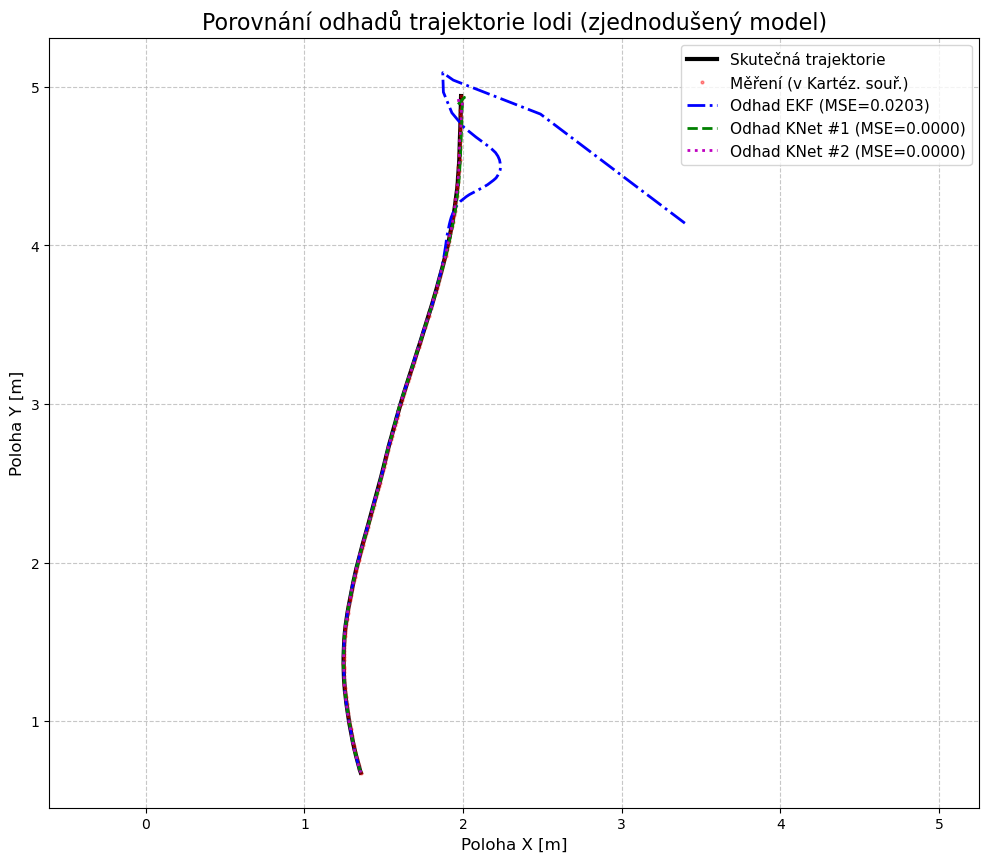

In [ ]:
plt.figure(figsize=(12, 10))
plt.title("Porovnání odhadů trajektorie lodi (zjednodušený model)", fontsize=16)

y_test_seq = y_test.squeeze(0).cpu()
angles = y_test_seq[:, 0].cpu()
distances = y_test_seq[:, 1].cpu()
y_meas_x = distances * torch.cos(angles)
y_meas_y = distances * torch.sin(angles)

plt.plot(x_true_pos[:, 0], x_true_pos[:, 1], 'k-', linewidth=3, label="Skutečná trajektorie")
plt.plot(y_meas_x, y_meas_y, 'r.', markersize=4, alpha=0.4, label="Měření (v Kartéz. souř.)")
plt.plot(x_hat_ekf_pos[:, 0], x_hat_ekf_pos[:, 1], 'b-.', linewidth=2, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet1_pos[:, 0], x_hat_knet1_pos[:, 1], 'g--', linewidth=2, label=f"Odhad KNet #1 (MSE={mse_knet1.item():.4f})")
plt.plot(x_hat_knet2_pos[:, 0], x_hat_knet2_pos[:, 1], 'm:', linewidth=2, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")

plt.xlabel("Poloha X [m]", fontsize=12)
plt.ylabel("Poloha Y [m]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.axis('equal')
plt.show()